In [1]:
import socket
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd

from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu
import s2widthcut_utility as wcu
import math
from datetime import datetime, timedelta
import cutax
from straxen.get_corrections import get_correction_from_cmt
from cutax.cuts import *

from tqdm import tqdm

In [2]:
straxen.print_versions()

,module,version,path,git
0,python,3.8.13,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.1/b...,None
1,strax,1.2.3,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.1/l...,None
2,straxen,1.8.1,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.1/l...,None
3,cutax,1.10.0,/dali/lgrandi/xenonnt/software/cutax/v1.10.0/c...,None


In [3]:
st = cutax.contexts.xenonnt_v8(cut_list=[cutax.cut_lists.basic.BasicCuts])
#st.register(FiducialVolumeCylinder)
#FiducialVolume0 = st.get_single_plugin('030000', 'cut_fiducial_volume_cylinder')
FiducialVolume = st.get_single_plugin('030000', 'cut_fiducial_volume')
NearWires = st.get_single_plugin('030000', 'cut_near_wires')

In [4]:
ev_sim = np.load('/dali/lgrandi/shenyangshi/s2_width_wfsim_0615.npy', allow_pickle=True)
ev_sim = ev_sim[FiducialVolume.cut_by(ev_sim)]

In [5]:
vd = get_correction_from_cmt('024075',('electron_drift_velocity', 'ONLINE', True))
gd = get_correction_from_cmt('024075',('electron_drift_time_gate', 'ONLINE', True))
dc = get_correction_from_cmt('024075',('electron_diffusion_cte', 'ONLINE', True))
par = (dc,vd,gd)
print(par)

(4.566e-08, 6.77e-05, 2700.0)


In [6]:
stmc=cutax.contexts.xenonnt_sim_SR0v1_cmt_v8()

*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [15]:
#sample = "SE"
sample = "Ar37"
# sample = "Kr83m"
mcfolder = "/dali/lgrandi/terliuk/wfsim_output/{:s}_sample/".format(sample)
stmc.storage.append(strax.DataDirectory(os.path.join(mcfolder,"strax_data"),
                                        readonly=True))

In [16]:
n_read=100
peak_basics = []
event_info = []
n_found_peaks=0
n_found_events=0
for i_file in tqdm(range(0,n_read)):
    run_id="{:s}_sample_{:04d}".format(sample, i_file)
    #print(run_id)
    if (stmc.is_stored(run_id, "peak_basics") and 
        stmc.is_stored(run_id, "peak_positions_mlp")):
        peak_basics.append(stmc.get_array(run_id, ["peak_basics", "peak_positions"], progress_bar=False))
        n_found_peaks+=1
    if stmc.is_stored(run_id, "event_info"):
        event_info.append(stmc.get_array(run_id, "event_info", progress_bar=False))
        n_found_events+=1
peak_basics= np.concatenate(peak_basics)
event_info= np.concatenate(event_info)
print("Found runs with peak_basics: {:d} of {:d}".format(n_found_peaks,n_read))
print("Found runs with event_info: {:d} of {:d}".format(n_found_events,n_read))

100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Found runs with peak_basics: 100 of 100
Found runs with event_info: 100 of 100


In [29]:
event_info = event_info[FiducialVolume.cut_by(event_info)]

In [38]:
def set_cut_on_wfsim(ev_sim, ev, width_type = '50p', near_wires = False, far_wires = False, wrange = (0,2),
                     perc =(1,99), afit=(2,3.6), acc_calc = False, nome = ''):
    mask_near_wires = NearWires.cut_by(ev_sim)
    mask_near_wires_ = NearWires.cut_by(ev)
    if near_wires:
        #ev = ev[ev['cut_near_wires']]
        ev = ev[mask_near_wires_]
        ev_sim = ev_sim[mask_near_wires]
    if far_wires:
        #ev = ev[ev['cut_near_wires']==False]
        ev = ev[~mask_near_wires_]
        ev_sim = ev_sim[~mask_near_wires]
    info = f'WFsim {nome}'
    name = f'cut_sim_{nome}_{width_type}_p{perc[0]}_p{perc[1]}'
    cut_sim=wcu.S2WidthCut(ev_sim, title=info, mod_par=par, perc=perc, bins=400, perc_plot=0,
                           wrange = wrange, real_data = 0, #ev_leak=ev_leak
                           plot = 1, arange = (2, 4.5), afit=afit,near_wires = near_wires,
                           width_type=width_type)#, name=name)
    if acc_calc:
        wcu.get_acceptance(ev_sim, cut_sim[1], title=info, bins = 40, alim=(0.8,1), name = f'{name}_')
    
    info = f'WFsim-Andrii {nome}'
    name = f'cut_data_{nome}_{width_type}'
    cut_data = wcu.S2WidthCut(ev, title=info, mod_par=par, perc_plot=0, bins=400,
                              wrange=wrange, near_wires = near_wires, #ev_leak=ev_leak
                              plot = 1, arange = (2.2,6.5), afit=afit,
                              width_type=width_type, #name=name,
                              ext_par=cut_sim[2])
    if acc_calc:
        wcu.get_acceptance(ev, cut_data[1], title=info, bins = 40, alim=(0.8,1), name = f'{name}_')
    return cut_sim[2]

Fit lower boundary: [0.64985444 3.07295896 1.04751234]
Fit upper boundary: [7.62310891 2.40119633 1.99292651 1.42086135]
param_parabola_low: [-0.01260342  0.28863764 -0.32810266]
param_parabola_high: [ 0.16628953 -1.72918487  5.738686  ]
Fit cut: total 579176, survived 570042 -> 98.42%
Lower and higher boundary provided externally
param_parabola_low: [-0.01260342  0.28863764 -0.32810266]
param_parabola_high: [ 0.16628953 -1.72918487  5.738686  ]
Fit cut: total 556661, survived 539814 -> 96.97%


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:520: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:520: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:520: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:520: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:520: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:520: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: Runti

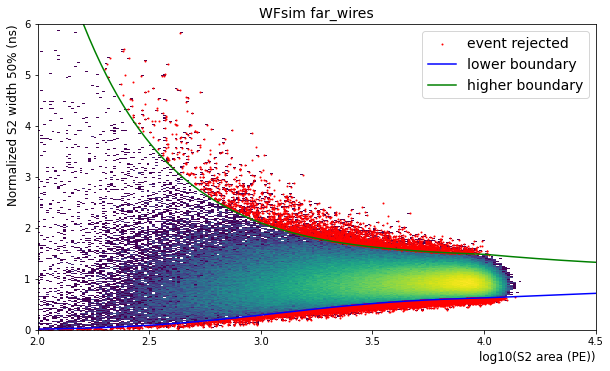

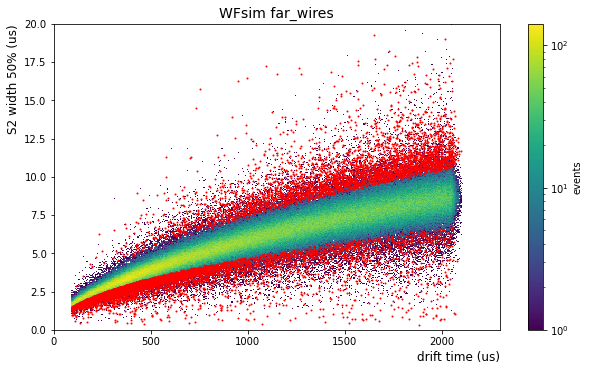

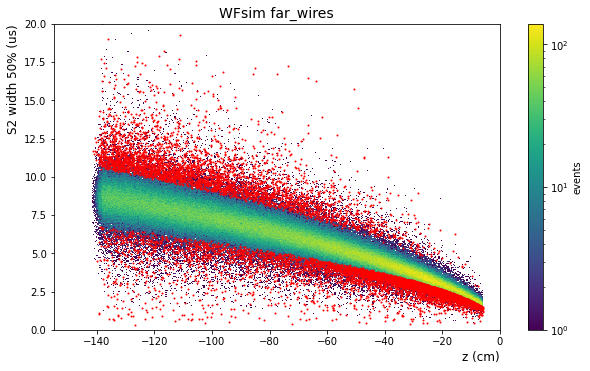

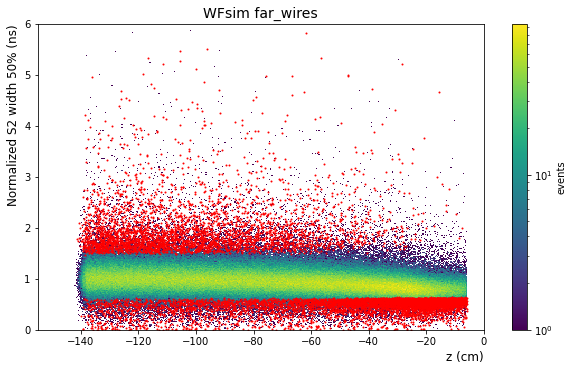

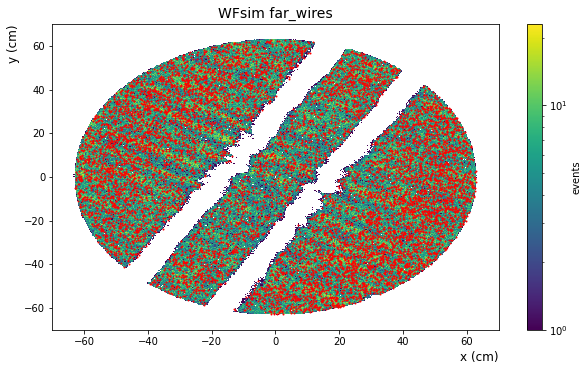

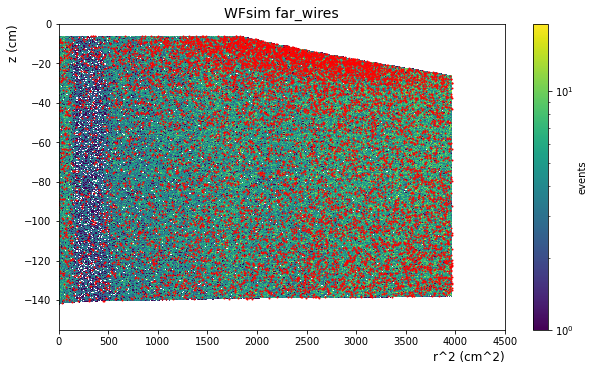

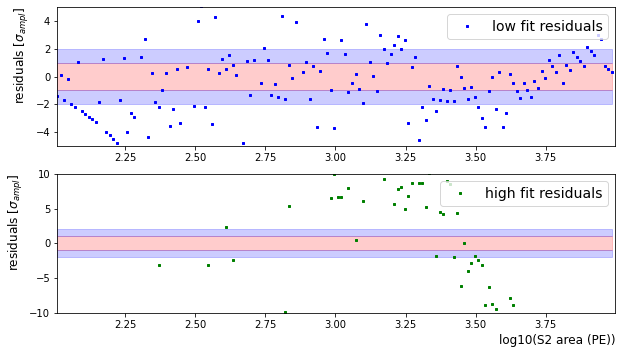

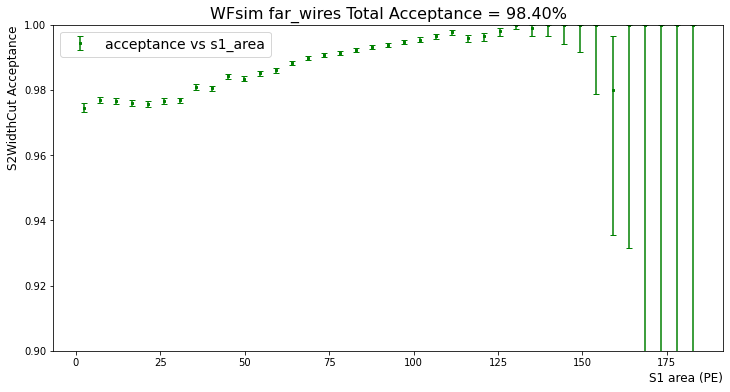

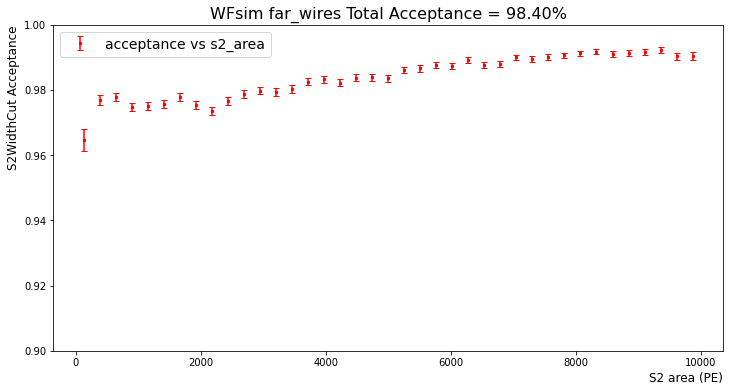

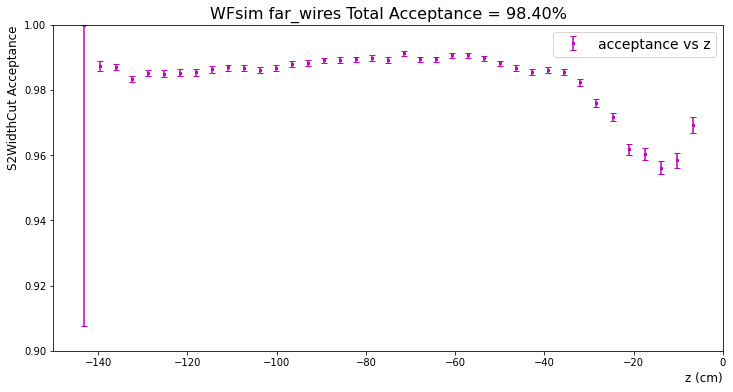

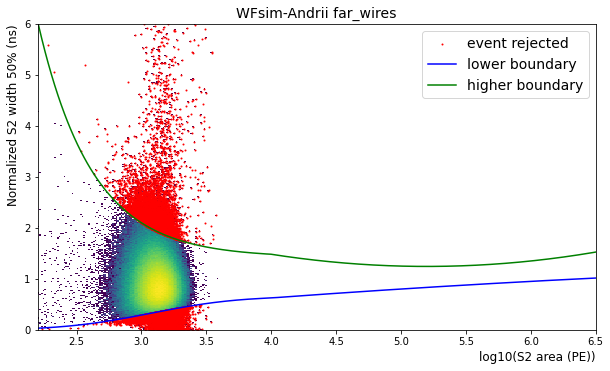

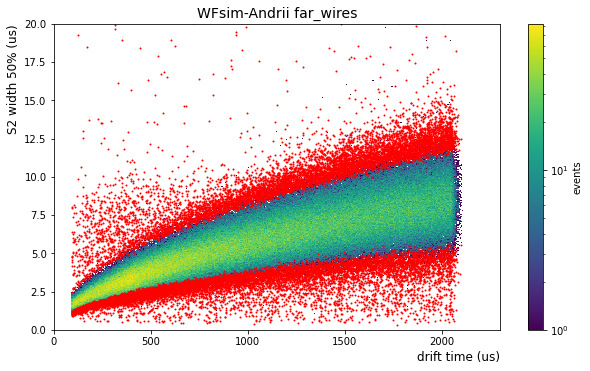

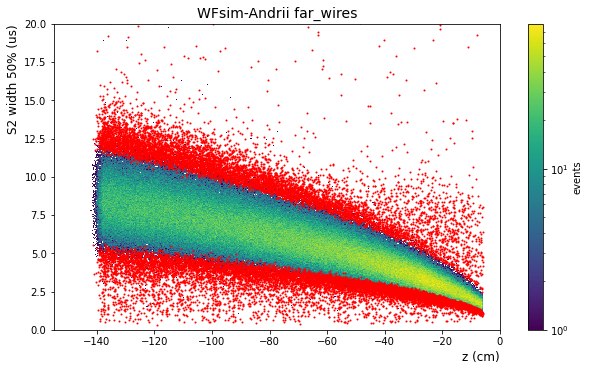

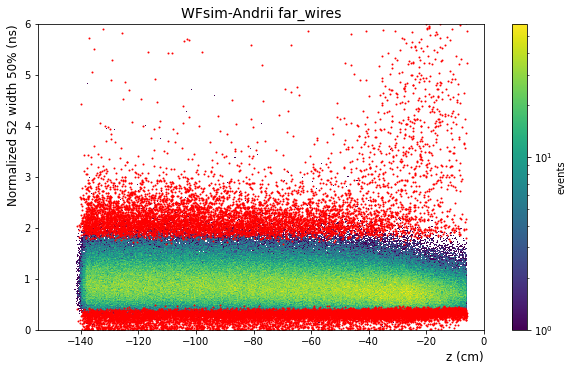

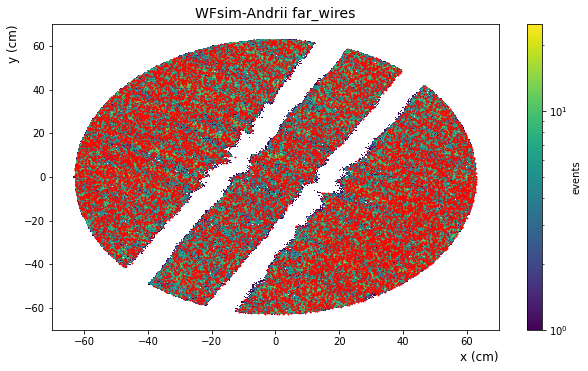

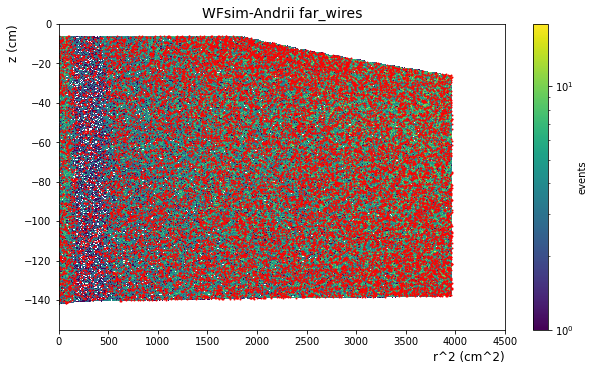

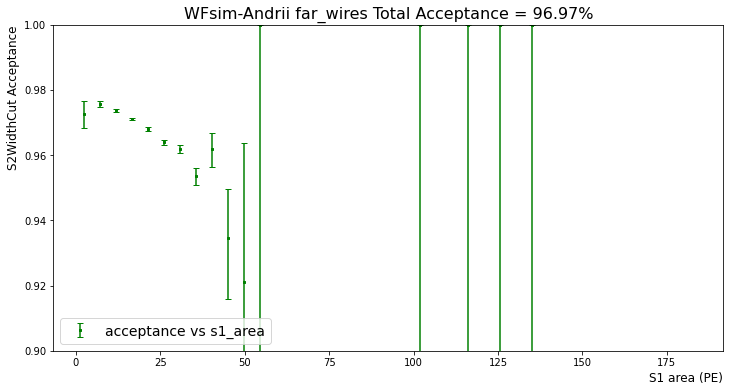

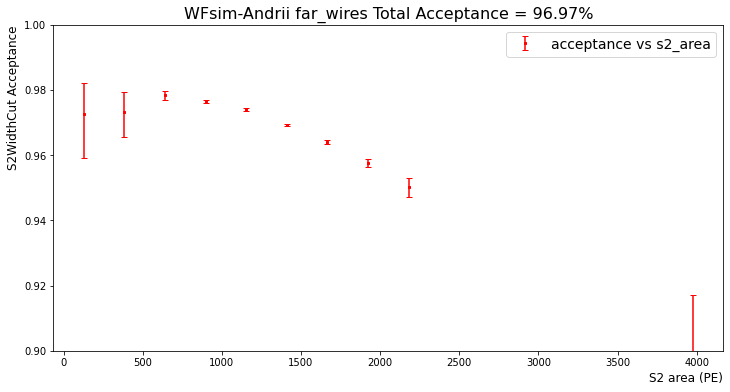

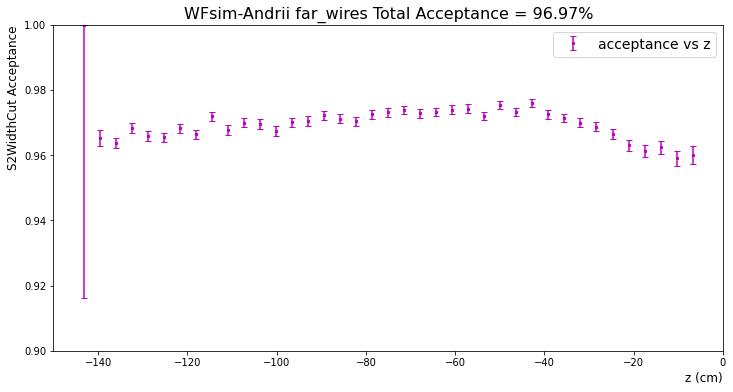

In [35]:
# FAR FROM WIRES 1-99%
cut_far = set_cut_on_wfsim(ev_sim, event_info, width_type='50p', perc=(1,99),wrange=(0,6),
                           afit=(2,4), far_wires = 1, acc_calc = 1,nome='far_wires')

Fit lower boundary: [0.77643766 2.93142744 1.40228207]
Fit upper boundary: [3.73670368 1.084261   1.98859265 1.02193364]
param_parabola_low: [ 0.03838374 -0.27222112  1.20151215]
param_parabola_high: [ 0.14726708 -1.51993783  5.16801225]
Fit cut: total 141235, survived 133984 -> 94.87%


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:520: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:520: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


Lower and higher boundary provided externally
param_parabola_low: [ 0.03838374 -0.27222112  1.20151215]
param_parabola_high: [ 0.14726708 -1.51993783  5.16801225]
Fit cut: total 136395, survived 127913 -> 93.78%


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:520: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:520: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:520: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:520: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valeri

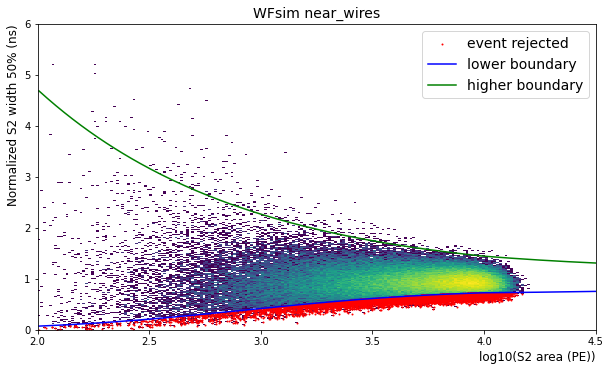

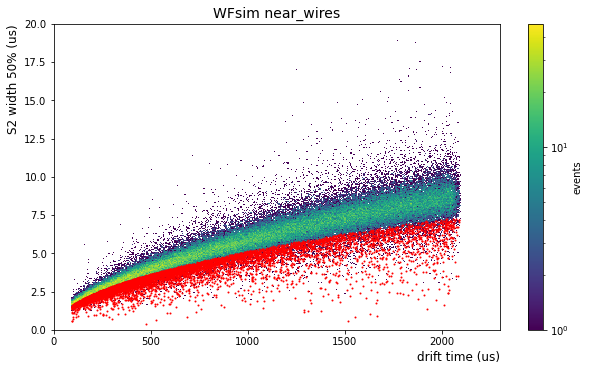

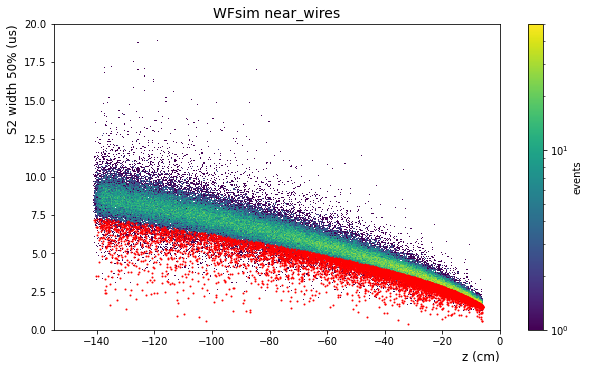

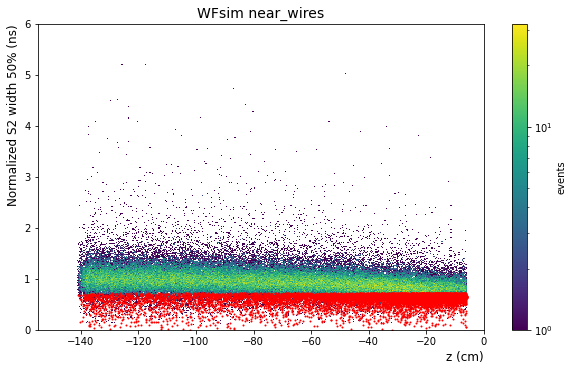

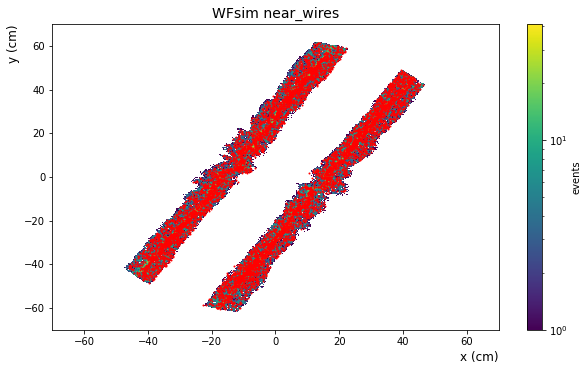

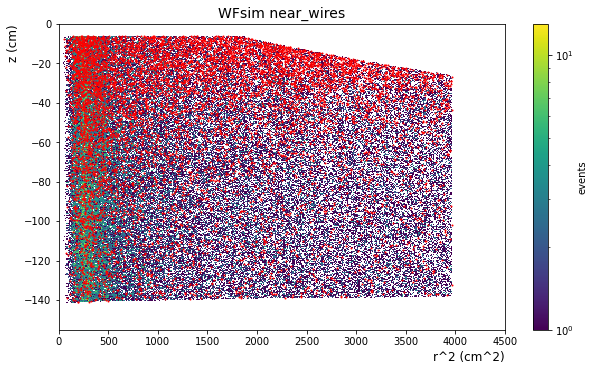

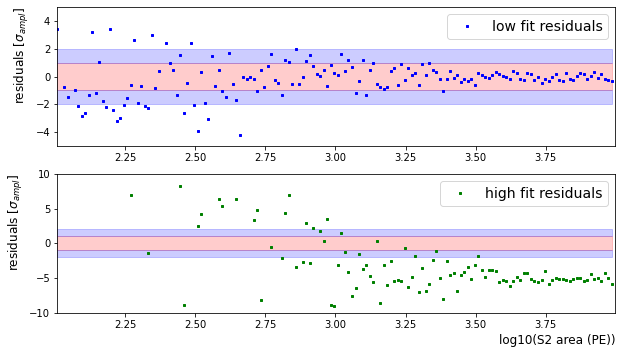

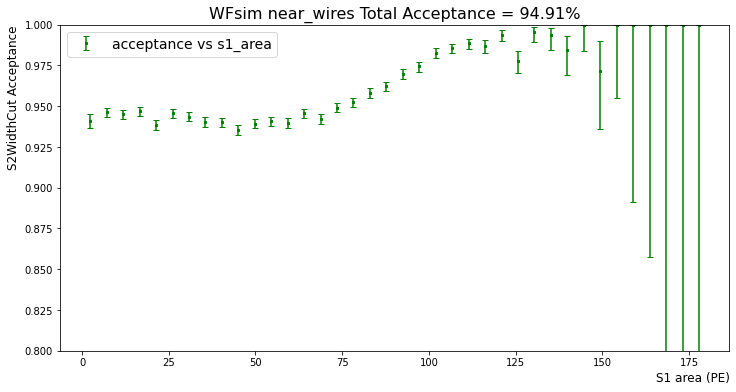

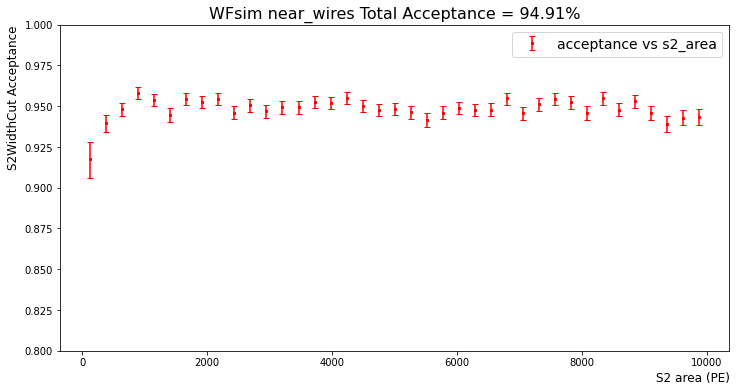

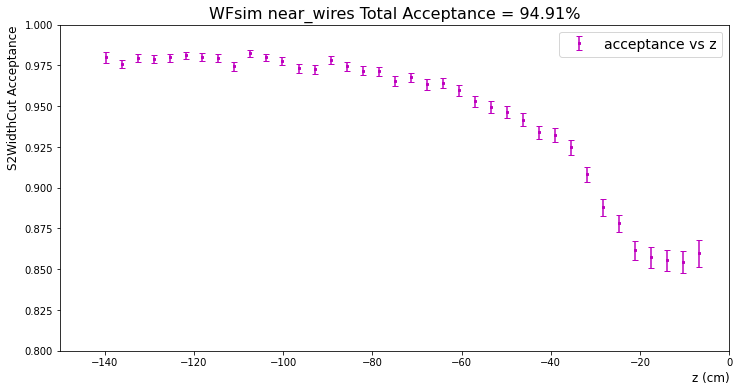

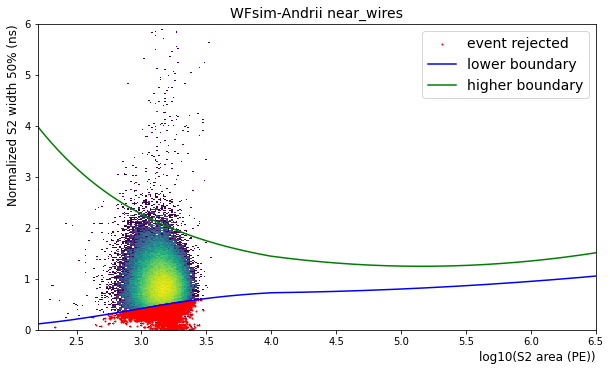

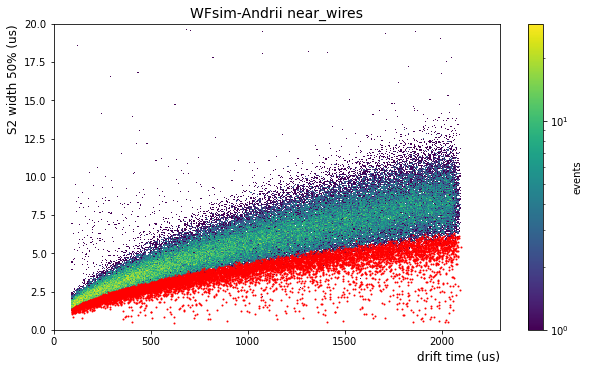

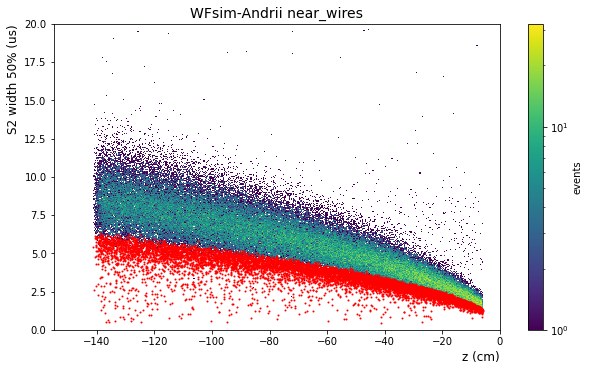

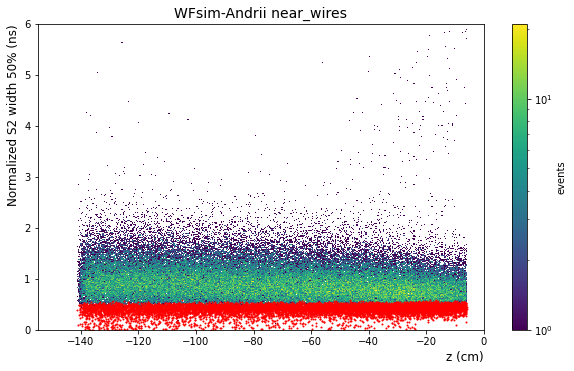

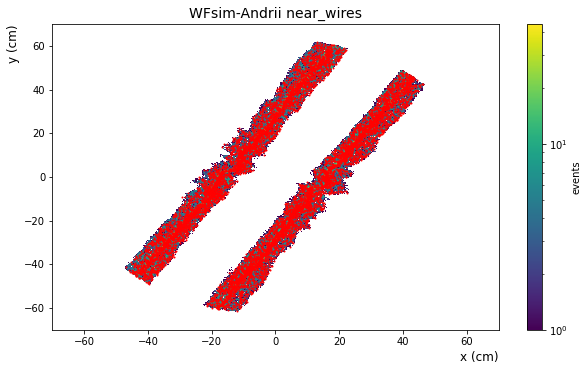

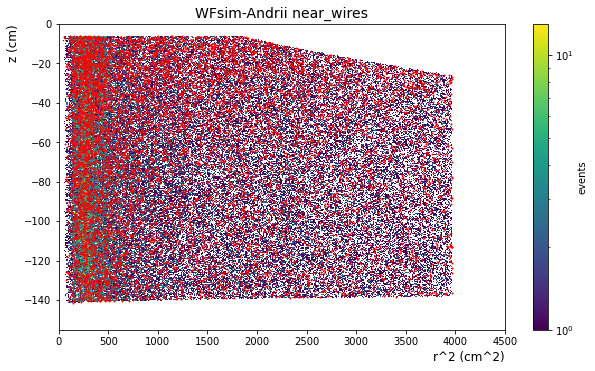

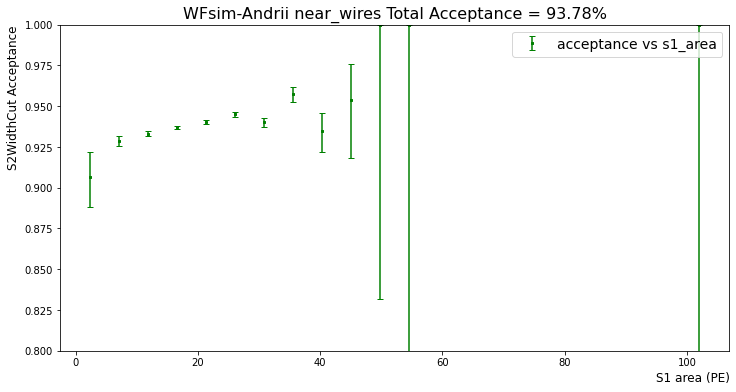

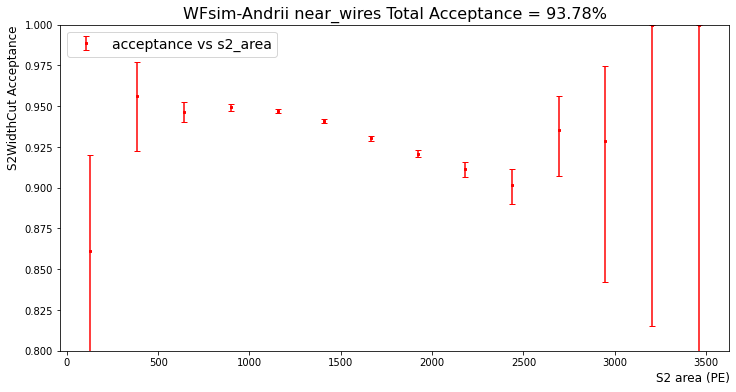

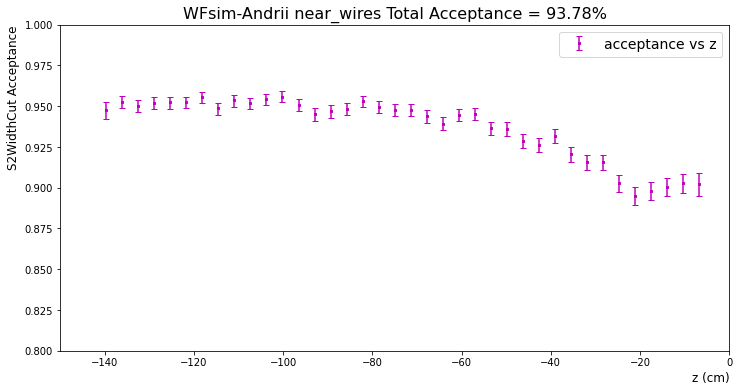

In [39]:
# NEAR WIRES WIMPs
cut_near = set_cut_on_wfsim(ev_sim, event_info, width_type='50p',perc=(5,99),wrange=(0,6),
                            afit=(2.,4), near_wires = 1, acc_calc=1, nome='near_wires')